In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from abc import abstractclassmethod, ABC
import multiprocess as mp 

<h1>Base Classes </h1>

In [3]:
class Environment(ABC):
    @abstractclassmethod
    def __init__(self):
        raise NotImplementedError("This is an abstract class")
        
    @abstractclassmethod
    def reset(self):
        raise NotImplementedError("This is an abstract class")
        
    @abstractclassmethod
    def step(self):
        raise NotImplementedError("This is an abstract class")
        
class Agent(ABC):
    @abstractclassmethod
    def __init__(self):
        raise NotImplementedError("This is an abstract class")
    
    @abstractclassmethod
    def reset(self):
        raise NotImplementedError("This is an abstract class")
    
    @abstractclassmethod
    def get_action(self):
        raise NotImplementedError("This is an abstract class")
    
    @abstractclassmethod
    def update_values(self):
        raise NotImplementedError("This is an abstract class")

<h1>Stationary Bandits and Action-Value Methods </h1>

In [4]:
class StationaryBandit(Environment):
    def __init__(self, K):
        self.K = K
        self.reset()
        
    def reset(self):
        self.steps = 0
        self.mean = np.random.randn(self.K)
        self.optimal_action = np.argmax(self.mean)
        
    def step(self, action):    
        if action >= K:
            raise ValueError("The action should be less than {0}!".format(self.K-1))
            
        self.steps += 1
        return self.mean[action] + np.random.randn()
    
class AgentGreedy(Agent):
    def __init__(self, K, eps):
        self.K = K
        self.eps = eps
        self.reset()
        
    def reset(self):
        self.Q = np.zeros(K)
        self.last_action = None
        self.steps = np.zeros(K)
            
    def get_action(self):
        if np.random.random() <= self.eps:
            self.last_action = np.random.randint(0, self.K)
            self.steps[self.last_action] += 1
            return self.last_action
        
        best_reward = np.where(self.Q == np.amax(self.Q))[0]
        self.last_action = np.random.choice(best_reward)
        self.steps[self.last_action] += 1
        return self.last_action
    
    def update_values(self, reward):
        self.Q[self.last_action] +=  (1/self.steps[self.last_action]) * (reward - self.Q[self.last_action])
        
class Run:
    def __init__(self, agent, env):
        self.agent = agent
        self.env = env
        
    def run(self):
        reward_per_step = np.zeros(self.num_steps)
        num_chose_opt = 0
        prob_chose_opt = np.zeros(self.num_steps)
        for i in range(self.num_steps):
            action = self.agent.get_action()
            if action == self.env.optimal_action:
                num_chose_opt += 1
            prob_chose_opt[i] = num_chose_opt / (i+1)
            reward = self.env.step(action)
            reward_per_step[i] = reward
            self.agent.update_values(reward)

        return reward_per_step, prob_chose_opt
    
    def plot(self, ax1, ax2, clr, label):
        ax1.plot(range(self.num_steps), self.average_reward, lw=2, 
                 c=clr, label=label)
        ax2.plot(range(self.num_steps), self.prob_choose_opt, lw=2, 
                 c=clr, label=label)
    
    def train(self, num_steps, num_runs):
        self.num_steps = num_steps
        self.num_runs = num_runs
        self.average_reward = np.zeros(self.num_steps)
        self.prob_choose_opt = np.zeros(self.num_steps)
        for i in range(self.num_runs):
            self.env.reset()
            self.agent.reset()

            rew, prob = self.run()
            self.average_reward += rew / self.num_runs
            self.prob_choose_opt += prob / self.num_runs

In [5]:
def eps_greedy_sim(eps, K, num_steps, num_runs):
    env = StationaryBandit(K)
    agent = AgentGreedy(K, eps)
    simulation = Run(agent, env)
    simulation.train(num_steps, num_runs)
    return simulation

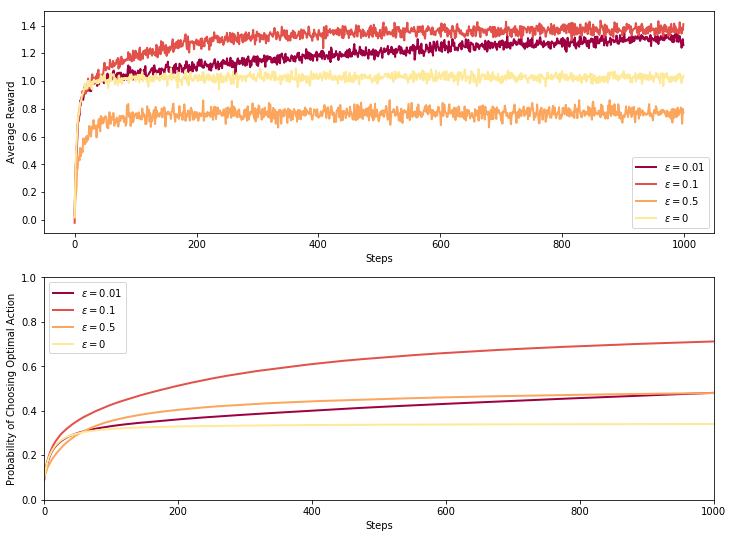

In [6]:
K = 10
eps = [0.01, 0.1, 0.5, 0]
num_runs = 2000
num_steps = 1000

fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_xlabel("Steps")
ax1.set_ylabel("Average Reward")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Probability of Choosing Optimal Action")
ax2.axis(xmin=0, xmax=num_steps, ymin=0, ymax=1)

greedy = lambda eps: eps_greedy_sim(eps, K, num_steps, num_runs)
pool = mp.Pool(processes=mp.cpu_count())
S = pool.map(greedy, eps)
pool.close()

color = iter(plt.cm.Spectral(np.linspace(0, 1, 2*len(eps))))
for i, simulation in enumerate(S):
    clr = next(color)
    simulation.plot(ax1, ax2, clr, r"$\epsilon = {0}$".format(eps[i]))
ax1.legend(loc="lower right")
ax2.legend(loc="upper left")

<h1>Non-Stationary Bandits</h1>

In [7]:
class NonStationaryBandit(StationaryBandit):
    def __init__(self, K, corr):
        self.corr = corr
        super().__init__(K)
        
    def step(self, action):    
        if action >= K:
            raise ValueError("The action should be less than {0}!".format(self.K-1))
            
        self.steps += 1
        reward = self.mean[action] + np.random.randn()
        self.mean = self.corr * self.mean + (1-self.corr) * np.random.randn(self.K)
        return reward

In [8]:
def non_stat_eps_greedy_sim(eps, K, num_steps, num_runs, corr):
    env = NonStationaryBandit(K, corr)
    agent = AgentGreedy(K, eps)
    simulation = Run(agent, env)
    simulation.train(num_steps, num_runs)
    return simulation

The action value methods perform poorly with non-stationary bandits because it's unable to keep track of the environment changes

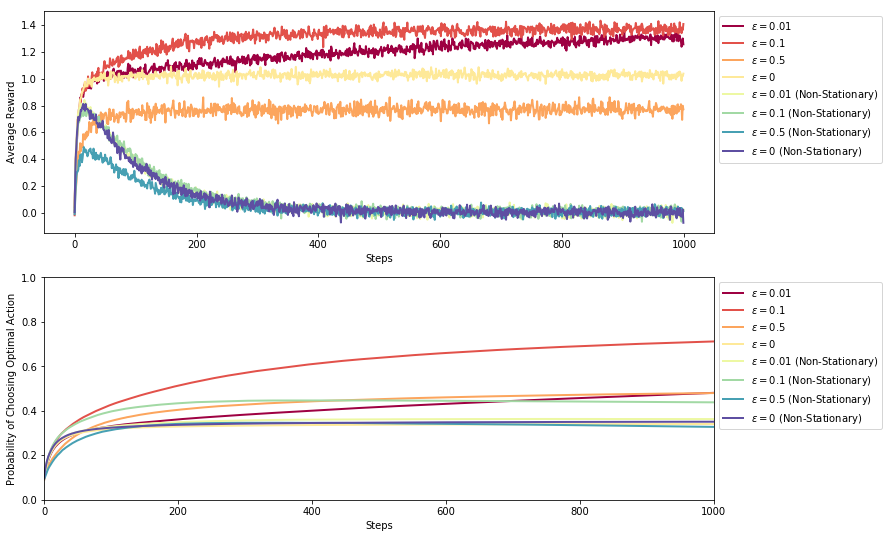

In [9]:
corr = 0.99

non_stat_greedy = lambda x: non_stat_eps_greedy_sim(x, K, num_steps, num_runs, corr)
non_stat_pool = mp.Pool(processes=mp.cpu_count())
S_non_stat = non_stat_pool.map(non_stat_greedy, eps)
non_stat_pool.close()

for i, simulation in enumerate(S_non_stat):
    clr = next(color)
    simulation.plot(ax1, ax2, clr, r"$\epsilon = {0}$ (Non-Stationary)".format(eps[i]))

ax1.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax2.legend(loc="upper left", bbox_to_anchor=(1, 1))
fig